<hr style="border:3px solid black"></hr>
Contact : dhilip@iitrpr.ac.in <br>

    - Apoorv Kushwaha & Dr. T.J. Dhilip Kumar
        Quantum Dynamics Lab (410), IIT Ropar.
***
# 2D multipole expansion code for a rigid rotor-atom collision PES:
*Uses Legendre functions from scipy library of python*

Paper :  https://doi.org/10.1002/qua.27007

<hr style="border:3px solid black"></hr>


<hr style="border:2px solid black"></hr>

### *Prepare input data ---> Import libraries ---> Create required folders*

    - Example Input  : Make Required changes in the cell as needed. [green]
    - Example Output : Describes the output of the cell. [indigo]

<hr style="border:2px solid black"></hr>

In [1]:
# Import required libraries
import math
import numpy as np
import pandas as pd
import os
from scipy.special import legendre
import matplotlib.pyplot as plt

In [2]:
# creating required folders
input_dir = os.getcwd()+'/'

out_plots = input_dir + 'plots/2D_MP/'
if not os.path.exists(out_plots):
    os.makedirs(out_plots)
out_data = input_dir + 'data/2D_MP/'
if not os.path.exists(out_data):
    os.makedirs(out_data)

<hr style="border:2px solid black"></hr>

### Read input file (PES)
*The code assumes:*

        - 1st column to be   R   (Radial Coordinate)
        - 2nd column to be theta (Angular coordinate)
        - 3rd column to be   E   (Potentials)
        - Remove any header such as r, theta, phi, etc from the input file
*** 
<span style="color:green"><u> Example Input</u></span>
     
    Input file: 2_inp_2D_PES.dat     # file name with R, theta and E
    Separation: \s+                  # \s+ : multiple spaces in separation. Other options are comma (,) and tab (\t), etc. 
    lm = 7                           # number of lambda terms (Number of radial terms must be <= Number of angular terms)
    *E_inf = NOT NEEDED              # *commented: input is already in cm-1
***

Use commented lines to convert energy to cm-1 (if input energies are in Hartree).
<hr style="border:2px solid black"></hr>

In [3]:
df_inp = pd.read_csv('2_inp_2D_PES.dat',header=None,sep='\s+')  # import file
lm = 7                                                          # define number of lambda terms 

# uncomment code below to convert energies from Hartree to cm-1.
#E_inf = -78.70465827                                      # define E_infinity (Asymptotic Energy)
#df_inp[2] = (df_inp[2] - E_inf)*219474.63                 # convert to cm-1

<hr style="border:2px solid black"></hr>

### Transforming data!
In this cell the input PES data is sorted by R and then by theta.
Remember that the PES should not have any coordinate missing and the energies are in cm-1 (code is designed that way) ! 
The given example has 181 radial and 7 angular coordinate 
(181*20 = 1267 data points).
***
<span style="color:indigo"><u> Example Output</u></span>
   
       Prints contents of df_inp (DataFrame containing input PES) 
***
<hr style="border:2px solid black"></hr>

In [4]:
df_inp.sort_values(by = [ 0,1], inplace=True, ascending = True)    # sort by (R, theta) in ascending order
df_inp.reset_index(inplace=True, drop = True)                      # Resetting index
print(df_inp)                                                      # preview of input file

         0   1             2
0      2.0   0  7.552939e+06
1      2.0  15  4.519685e+06
2      2.0  30  1.224973e+06
3      2.0  45  1.891939e+05
4      2.0  60  2.990607e+04
...    ...  ..           ...
1262  20.0  30 -0.000000e+00
1263  20.0  45 -0.000000e+00
1264  20.0  60 -0.000000e+00
1265  20.0  75 -0.000000e+00
1266  20.0  90 -0.000000e+00

[1267 rows x 3 columns]


<hr style="border:2px solid black"></hr>

### Declare Variables
*** 

<span style="color:green"><u> Example Input</u></span>

    symmetric = True/False      # If rigid rotor is symmetric enter True, else False
***
Rest of the variables are declared directly based on input dataset!
<hr style="border:2px solid black"></hr>

In [5]:
R_arr = df_inp[0].unique()       # extracting unique values of R (sorted)
gm_arr = df_inp[1].unique()      # extracting unique values of theta (sorted)
nc = len(df_inp[0].unique())     # number of Radial coordinates (Must be same for all angles)
ngm = len(df_inp[1].unique())    # number of angular coordinates

px = np.zeros((ngm,lm))          # Matrix to stores legendre coeffinients
f = np.zeros(ngm)                # Array to store part of ab initio energy 
R = np.zeros(nc)                 # Array for distance R
E = np.zeros(nc)                 # Array to store multipole expanded potentials
df_out = pd.DataFrame()          # dataframe that stores final V lambda (Radial coefficients)

V_nf= np.zeros((nc,lm))     # Numpy 2D array to store V_lambdas as they are calculated for each radial term
V_n= np.zeros(lm)           # Stores V_lambda for one radial term (Depreciated part of code no longer used!)

symmetric = True            # Verify if rigid rotor is symmetric (else put False)
if symmetric:
    sym = 2
else:
    sym = 1

<hr style="border:2px solid black"></hr>

### Calculate legendre coefficients
***
#### <u>Two Choices for legendre coefficients</u>:
    
    1) First Time: Run the next tab to generate new coefficients 
    2) Later runs: Skip the next tab to load previously generated coefficients from a numpy file
***
<span style="color:indigo"><u> Example output for next cell</u></span>

    Legendre coefficients are calculated and automatically saved to /data/2D_MP/2D_L_coeff.npy
***
For the example case : no. of angular terms = no. if radial terms.
       Therefore, pseudo-inverse is equivalent to simple matrix inverse!
<hr style="border:2px solid black"></hr>

In [6]:
# to generate new coefficients, run this cell
for j2 in range (ngm):                 # loop over anglular terms (goes from 0 to ngm-1)
    j2_ang = gm_arr[j2]                # angles go from 0-90 with 15 degree interval saved in gm_arr array
    for j3 in range (lm):              # loop over legendre terms (goes from 0 to lm-1)
        pxc = legendre(j3*sym)         # Uses j3*2 for symmetric molecule (only even V_lambdas); and *1 otherwise
        ang = math.radians(j2_ang)     # convert angles to radians
        px[j2,j3]= pxc(math.cos(ang))  # store legendre coefficient for corrosponding angle and lambda (2D)

np.save(out_data + "2D_L_coeff.npy", px)    # save Legendre coefficients to numpy readable file for future use

In [7]:
# to load previously saved Legendre coefficients, run this cell
px = np.load(out_data + "2D_L_coeff.npy")

<hr style="border:2px solid black"></hr>

###  Take pseudo-inverse of Legendre coefficients and calculate V_lambda
In this cell the input potentials (for each R at all angular coordinates) are multiplied by inverse matrix (A_inv) of Legendre coefficients.
The same is repeated for all R values to get radial coefficients across entire surface and saved to df_Vnf.
***
<span style="color:indigo"><u> Example Output</u></span>
   
       Prints contents of df_Vnf (DataFrame containing radial coefficients) around minima region.
       Prints maxima and minima for isotropic and first anisotropic term. 
       The final radial coefficients with R values (first row) are saved in data/2D_MP/2D_Vlam.dat
<hr style="border:2px solid black"></hr>

In [8]:
A_inv = np.linalg.pinv(px)     # take pseudo-inverse of px matrix (equivalent to least squares fit)
for i in range (nc):           # loop over all R   
    ct = i*ngm                 # extract start point. Since input dataframe is sorted by R and theta, 
    f = df_inp[2][ct:ct+ngm]   # potentials (V) are extracting for each R value at a time 
    V_n1 = A_inv.dot(f)        # A-inv * V gives Radial coefficients
    V_nf[i,:] = V_n1           # radial coefficients stored in 2D matrix

a12 = np.arange(lm)*sym                     # creates header for lambda terms
df_Vnf = pd.DataFrame(V_nf, columns = a12)  # saves final matrix into dataframe with appropriate header
df_Vnf.insert(0, 'R', R_arr)                # adding R column

df_Vnf.to_csv(out_data + '2D_Vlam.dat', index=None, header=True,
                sep=',')    # save V_lam coefficients to file separated by comma

print("minima & maxima for isotropic term: ", 
      min(df_Vnf[0]), max(df_Vnf[0]))           # prints minima & maxima for isotropic term
print("minima & maxima for first anisotropic term: ", 
      min(df_Vnf[1*sym]), max(df_Vnf[1*sym]))   # prints minima & maxima for first anisotropic term

print("The 15th to 30th terms are: \n ")    # prints first few terms
df_Vnf[15:30]

minima & maxima for isotropic term:  -13.485082511492212 556671.2750251472
minima & maxima for first anisotropic term:  -12.247123382116653 2145277.462415224
The 15th to 30th terms are: 
 


,R,0,2,4,6,8,10,12
15,3.5,1268.607927,5187.605986,5520.501182,3659.755338,1810.290858,950.005618,423.845591
16,3.6,817.100179,3401.910369,3646.542246,2428.336525,1204.929847,632.397606,281.491929
17,3.7,519.797136,2218.372963,2400.257112,1607.004192,800.165714,420.002345,186.477837
18,3.8,325.033091,1436.426592,1573.413828,1060.286350,529.998855,278.213337,123.182347
19,3.9,198.260580,921.736097,1026.352978,697.175342,350.020150,183.741839,81.106914
20,4.0,116.422105,584.470637,665.540093,456.611055,230.381246,120.932844,53.204019
21,4.1,64.161502,364.666133,428.430209,297.682890,151.044681,79.275853,34.749732
22,4.2,31.276441,222.374672,273.273068,193.022212,98.577578,51.723034,22.581395
23,4.3,11.007955,131.041859,172.252620,124.350019,63.987335,33.556099,14.585714
24,4.4,-1.107230,73.061085,106.876433,79.480870,41.263781,21.620685,9.352676


<hr style="border:2px solid black"></hr>

### Plots 
<span style="color:indigo"><u> Example Output</u></span>
   
       Plots each V_lambda individually (at different x, y limits) and saves in /plots/2D_MP/
       Plots all V_lambda combined and saves in /plots/2D_MP/
       X axis is in Angstroms and Y is in cm-1. 
<hr style="border:2px solid black"></hr>

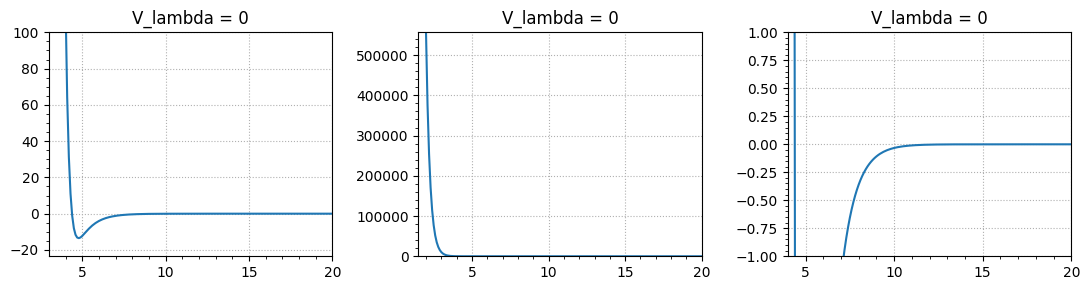

----------------------------------------------------------------------------------------------------




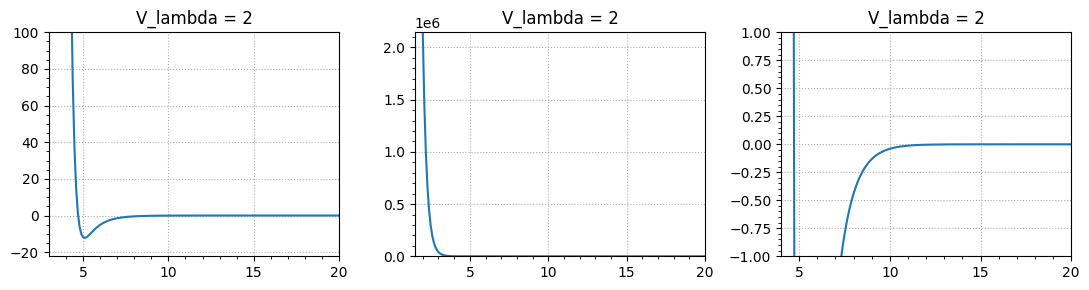

----------------------------------------------------------------------------------------------------




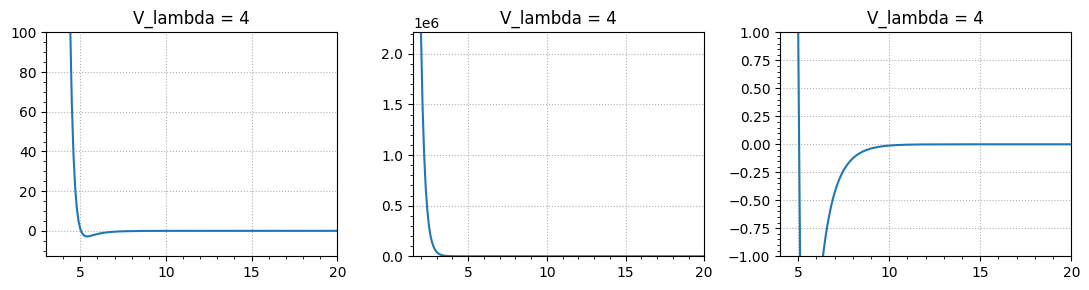

----------------------------------------------------------------------------------------------------




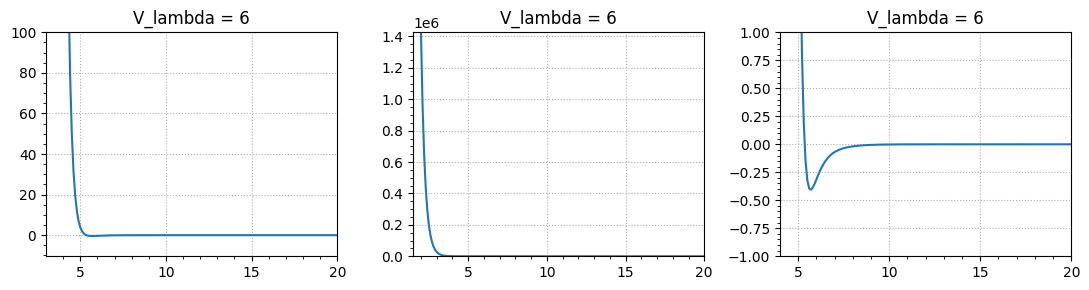

----------------------------------------------------------------------------------------------------




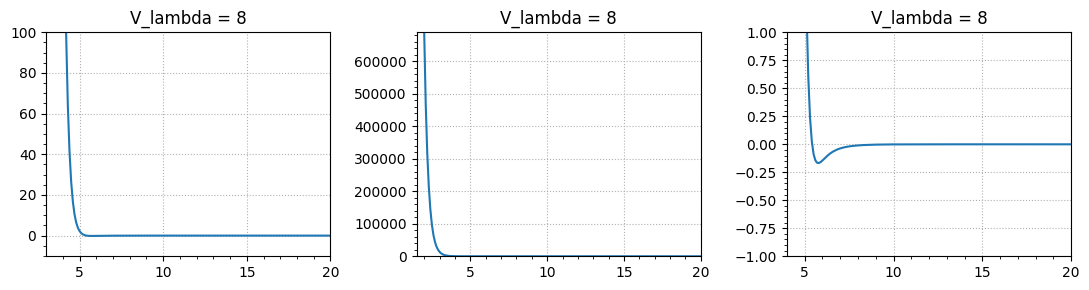

----------------------------------------------------------------------------------------------------




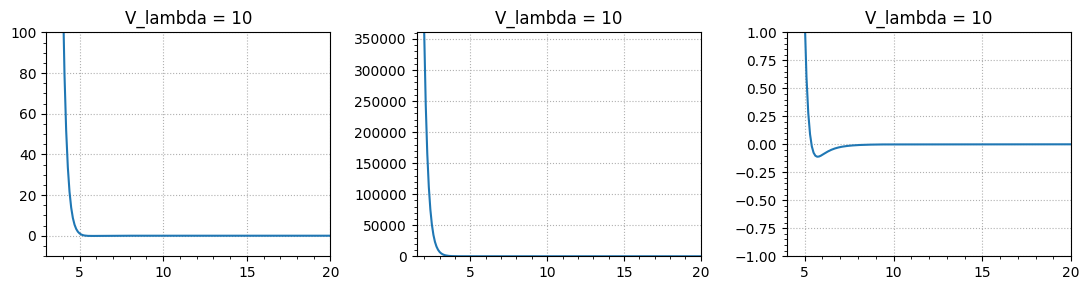

----------------------------------------------------------------------------------------------------




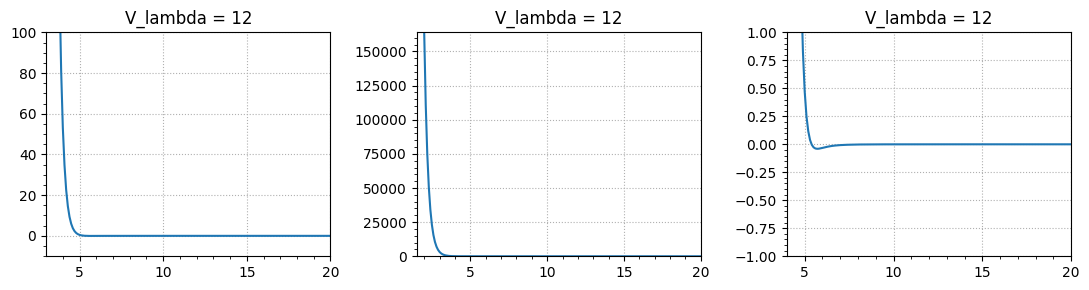

----------------------------------------------------------------------------------------------------




In [9]:
# Plot raw data separately
for i in range(0,lm):               # loop over V_lambda terms
    y_dummy = df_Vnf[i*sym]         # stores individual V_lambda for each loop
    plt.figure(figsize=(11,3))      # size of figure
    
    # Plot each V_lambda_separately to view features
    plt.subplot(1,3,1)                      # first subplot at visually appropriate x, y limit
    plt.plot(R_arr, y_dummy)                    # first plot
    plt.grid(True,linestyle=':')                # grid on
    plt.minorticks_on()                         # minor ticks are on
    plt.title("V_lambda = %d" %(i*sym))         # title of plot
    plt.ylim(max(y_dummy.min()-10,-200), 100)   # y limit
    plt.xlim(3, R_arr.max())                    # x limit
    
    plt.subplot(1,3,2)                      # second subplot at maximum x, y limit
    plt.plot(R_arr, y_dummy)
    plt.grid(True,linestyle=':')
    plt.minorticks_on() 
    plt.title("V_lambda = %d" %(i*sym))
    plt.ylim(y_dummy.min(), y_dummy.max())
    plt.xlim(R_arr.min()-0.5, R_arr.max())

    plt.subplot(1,3,3)                      # third subplot at zoomed in y limit [-1, +1]
    plt.plot(R_arr, y_dummy)
    plt.grid(True,linestyle=':')
    plt.minorticks_on() 
    plt.title("V_lambda = %d" %(i*sym))
    plt.ylim(-1, 1)
    plt.xlim(4, R_arr.max())
    plt.savefig(out_plots+'V_lam_{}.eps'.format(i*sym), 
                format='eps')               # save individual figure
    
    plt.tight_layout()                      # tight layout
    plt.show()                              # show individual plot
    print('-----'*20)
    print('\n')
    

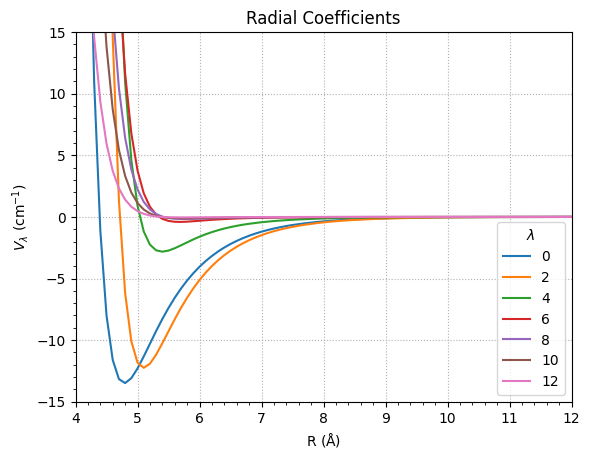

<Figure size 640x480 with 0 Axes>

In [10]:
# Plot individual V_lam together

for i in range(0,lm):                                      # loop over V_lambda terms
    y_dummy = df_Vnf[i*sym]                                # stores individual V_lambda for each loop 
    # Plot the data
    plt.plot(R_arr, y_dummy,label='{}'.format(i*sym))      # plot each V_lambda
    plt.grid(True,linestyle=':')                           # grid on
    plt.minorticks_on()                                    # minor ticks on
    plt.legend(title = r'$\lambda $', loc ="lower right")  # name and position of legend
    plt.title("Radial Coefficients")                       # title of plot
    plt.xlabel(r'R $\mathrm{(\AA)}$')                      # X label (written in latex $...$ format)
    plt.ylabel(r'$V_\lambda$ $(\mathrm{cm}^{-1})$')        # Y label (written in latex $...$ format)
    plt.ylim(-15, 15)                                      # y limit (y_min, y_max)
    plt.xlim(4, 12)                                        # x limit (x_min, x_max)
plt.show()                                                 # to combine individual plots, plt.show() is used outside loop.

plt.savefig(out_plots+'Combined_V_lam.eps', format='eps')  # save combined figure

<hr style="border:2px solid black"></hr>

### Save data for further use 
    1) either directly into MOLSCAT using VSTAR/VRTP (USE: 2D_Vlam.dat)
    2) OR curve fit into appropriate functions and then use in MOLSCAT (&POTL) 

#### For second option goto CODE 4
<hr style="border:2px solid black"></hr>